<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Finite-State-Machine" data-toc-modified-id="Finite-State-Machine-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Finite State Machine</a></span></li><li><span><a href="#Model-Development" data-toc-modified-id="Model-Development-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Model Development</a></span></li><li><span><a href="#Performance-Assessment" data-toc-modified-id="Performance-Assessment-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Performance Assessment</a></span></li><li><span><a href="#Next-Steps" data-toc-modified-id="Next-Steps-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Next Steps</a></span></li></ul></div>

# Finite State Machine

Following the requirements outlined in the Project 1 description, the following finite state machine was created. Essentially this FSM consists of four states: waiting, timing, running, and finished. The program will begin in the waiting state. In this state, the Zumo is not moving and is waiting for input from the user to move into the timing state. Upon a unique press of button C on the Zumo, it will enter the timing state. The Zumo will remain in this state for 2 seconds and emit a tone at 40kHz as to symbolize a "return to base" signal. Once the 2 seconds is surpassed, the Zumo will enter the running state. In this state, voltages determined from the model will be written to the Zumo's motor to travel the desired distance in the desired time. During the running state, the yellow LED on the Zumo will be flashing at 2Hz. The Zumo will then enter the finished state once the designated time has surpassed. In the finished state the Zumo will stop and emit a tone at 50kHz for 2 seconds to signify the end of the run. After the 2 seconds have gone by, it will return to the waiting state to await another input from the user. 

The following diagram shows the state transition diagram for this finite state machine with accompanying logic:

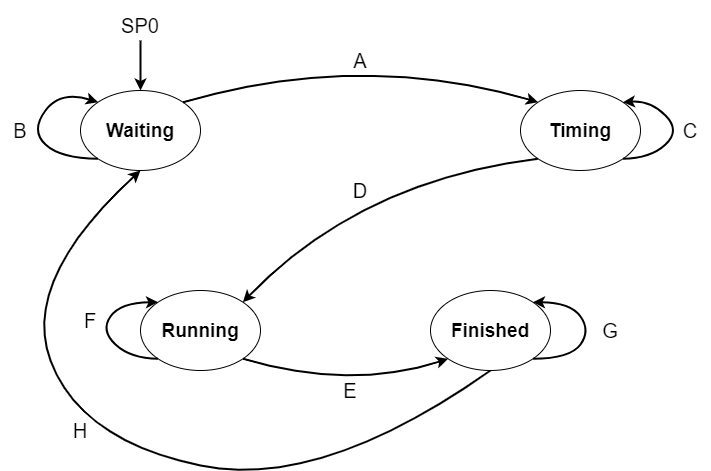

|Transition|Starting State|Transition Condition|Ending State|
|:---:|:---:|:---:|:---:|
|A|Waiting|$BUTTON4$|Timing|
|B|Waiting|$\overline{BUTTON4}$|Waiting|
|C|Timing|$\overline{TMR1}$|Timing|
|D|Timing|$TMR1$|Running|
|E|Running|$TMR2$|Finished|
|F|Running|$\overline{TMR2}$|Running|
|G|Finished|$\overline{TMR3}$|Finished|
|H|Finished|$TMR3$|Waiting|

Below is the Arduino script for the FSM. It should be noted that the timer FSMs are not included, but are fundementally all identical and just differ on the timer duration and when they are enabled. 

```javascript
//waiting represents the waiting state
//timing represents the timing state
//vroom represents the state where the zumo is running
//finished represents the state where the zumo is finished and playing its end tone

//waitingToTiming represents the transition from the waiting to timing state
//waitingLatch represents the latch on the waiting state
//timingLatch represents the latch on the timing state
//timingToVroom represents the transition from the timing to the running state
//vroomToWaiting represents the transition from the running to waiting state
//vroomLatch represents the latch on the running state
//vroomToFinish represnts the transition from the running to the finished state
//finishLatch represents the latch on the finished state
//finishToWaiting represnts the transition from the finished to the waiting state

//buttonC represents the button C on the Zumo
//motors represents the motors on the Zumo
//LCD represents the Liquid Crystal Display on the Zumo
//buttonPress represents a unique press of button C
//buzzer represents represents the buzzer on the Zumo which plays beeps and music
//TMR1 represents the first timer that times the first tone sounding
//TMR2 represents the second timer that times the duration of the run 
//TMR3 represents the third timer that times the second tone sounding
//timer2Limit represents the time limit that the Zumo will travel the desired distance in
//interval represents the interval at which the LED will blink
//ledState represents the state of the LED (LOW = OFF, HIGH = ON)
//previousMillis represents the past time in milliseconds (used to time the blinking of the LED)
//currentMillis represents the current time in milliseconds (used to time the blinking of the LED)
//motorCountLeft represents the count value being written to the left motor
//motorCountRight represents the count value being written to the right motor
//voltageLeft1 represents the voltage supplied to the left motor (determined from MATLAB)
//voltageLeft2 represents the voltage supplied to the right motor (determined from MATLAB)


#include <Wire.h>
#include <Zumo32U4.h>

Zumo32U4ButtonC buttonC;
Zumo32U4Buzzer buzzer;
Zumo32U4Encoders encoders;
Zumo32U4Motors motors;
Zumo32U4LCD LCD;

boolean buttonPress;
bool TMR1 = false;
bool TMR2 = false;
bool TMR3 = false;
float timer2Limit = 2000; // this will be changed to the desired time
const long interval = 250;
int ledState = LOW;
unsigned long previousMillis = 0;
float motorCountLeft = 0;
float motorCountRight = 0;
float voltageLeft1 = 2.9830252945082361895663876939604; // this will be changed depending on the desired distance and time
float voltageRight1 = 3.0370336678350572459716412928022; // this will be changed depending on the desired distance and time

bool waiting = 1;
bool timing = 0;
bool vroom = 0;
bool finished = 0;

bool waitingToTiming = 0;
bool waitingLatch = 0;
bool timingLatch = 0;
bool timingToVroom = 0;
bool vroomLatch = 0;
bool vroomToFinish = 0;
bool finishLatch = 0;
bool finishToWaiting = 0;

void setup() {
  Serial.begin(115200);

}

void loop() {
  // BLOCK 1: Process Inputs
  //----------------------------------------
  float batteryPower = readBatteryMillivolts() * 1E-3;
  unsigned long currentMillis = millis(); //defining current time
  buttonPress = buttonC.getSingleDebouncedPress();
  TMR1 = Timer(timing, 2000);
  TMR2 = Timer2(vroom, timer2Limit);
  TMR3 = Timer3(finished, 2000);

  // BLOCK 2: State Transition Logic
  //----------------------------------------
  waitingToTiming = waiting && buttonPress;
  waitingLatch = waiting && !buttonPress;
  timingLatch = timing && !TMR1;
  timingToVroom = timing && TMR1;
  vroomToFinish = vroom && TMR2;
  vroomLatch = vroom && !TMR2;
  finishLatch = finished && !TMR3;
  finishToWaiting = finished && TMR3;


  // BLOCK 3: Update States
  //----------------------------------------
  waiting = finishToWaiting || waitingLatch;
  timing = waitingToTiming || timingLatch;
  vroom = timingToVroom || vroomLatch;
  finished = vroomToFinish || finishLatch;

  // BLOCK 4: Set Outputs and Old Variables
  //----------------------------------------
  if (waiting == 1) {
    Serial.print("waiting");
    LCD.gotoXY(0, 1);
    LCD.print(1);
    LCD.print(0);
    LCD.print(0);
    LCD.print(0);
    ledYellow(0);
    motorCountLeft = 0;
    motorCountRight = 0;
  }

  if (timing == 1) {
    Serial.print("timing");
    LCD.gotoXY(0, 1);
    LCD.print(0);
    LCD.print(1);
    LCD.print(0);
    LCD.print(0);
    ledYellow(0);
    buzzer.playFrequency(40000, 100, 11);
    motorCountLeft = 0;
    motorCountRight = 0;
  }

  if (vroom == 1) {
    Serial.print("vroom");
    LCD.gotoXY(0, 1);
    LCD.print(0);
    LCD.print(0);
    LCD.print(1);
    LCD.print(0);
    //blinking LED
    if (currentMillis - previousMillis >= interval) {
      previousMillis = currentMillis;
      if (ledState == LOW) {
        ledState = HIGH;
        ledYellow(1);
      } else {
        ledState = LOW;
        ledYellow(0);
      }
    }
    motorCountLeft = (400 * voltageLeft1 ) / batteryPower;
    motorCountRight = (400 * voltageRight1 ) / batteryPower;
  }

  if (finished == 1) {
    Serial.print("finished");
    LCD.gotoXY(0, 1);
    LCD.print(0);
    LCD.print(0);
    LCD.print(0);
    LCD.print(1);
    ledYellow(0);
    motorCountLeft = 0;
    motorCountRight = 0;
    buzzer.playFrequency(50000, 100, 11);
  }

  motors.setLeftSpeed(motorCountLeft);
  motors.setRightSpeed(motorCountRight);
  Serial.println();
}
```

One important explanation is the determination of the count value to write to the motors (0-400 to go forwards) that corresponds to the input voltages. In order to account for the non-ideality of the Zumo's batteries, I created a ratio that correlated the maximum count (400) to the maximum voltage my batteries could supply that was read with every loop iteration. This ensured that the count value delivered to the motors accurrately corresponded to the input voltages. 

# Model Development

In order to accurately predict the Zumo's behavior, I decided to model the motors separately as I noticed that the Zumo would drive slightly crooked when the same voltages were written to both the left and right motors. The first step in model development is model scoping and determination of the desired input and outputs. For the two motor models, I chose an input of source voltage supplied to the motors and an output of angular velocity of the motor. 

The next step was to determine the order of the system model. From initial data collection (shown below), I decided to model the motors as first order. This indicates that there is only one energy storing element. The one energy storing element is the rotational mass of the motor. This element was chosen as the only independent energy storing element in the system as the turbine must have rotational inertia in order for us to see an output of the turbine angular speed ($\Omega$). There is also a dissipative element which causes the motor to approach at a steady state angular velcity. This dissipative element is the damping between the motor and ground. This model must have a dissipative element or else the motor would be able to continuously spin when given a step input, making it a perpetual motion machine which is inherently impossible. There is also a transducer that converts between electrical and rotational mechanical energy and a resistor in the electrical circuit between the source voltage and the voltage supplied to the transducer. A resistor is required because the voltage drop across the transducer is proportional to the output angular velocity of the motor. If there were to be no resistor and a theoretical infinite voltage source, there would be no voltage drop, resulting in an angular velocity of zero and infinite current. If there were an infinite current, the motor torque would subsequently also be infinite, we know this is impossible as there is a maximum stall torque associated with the motor.

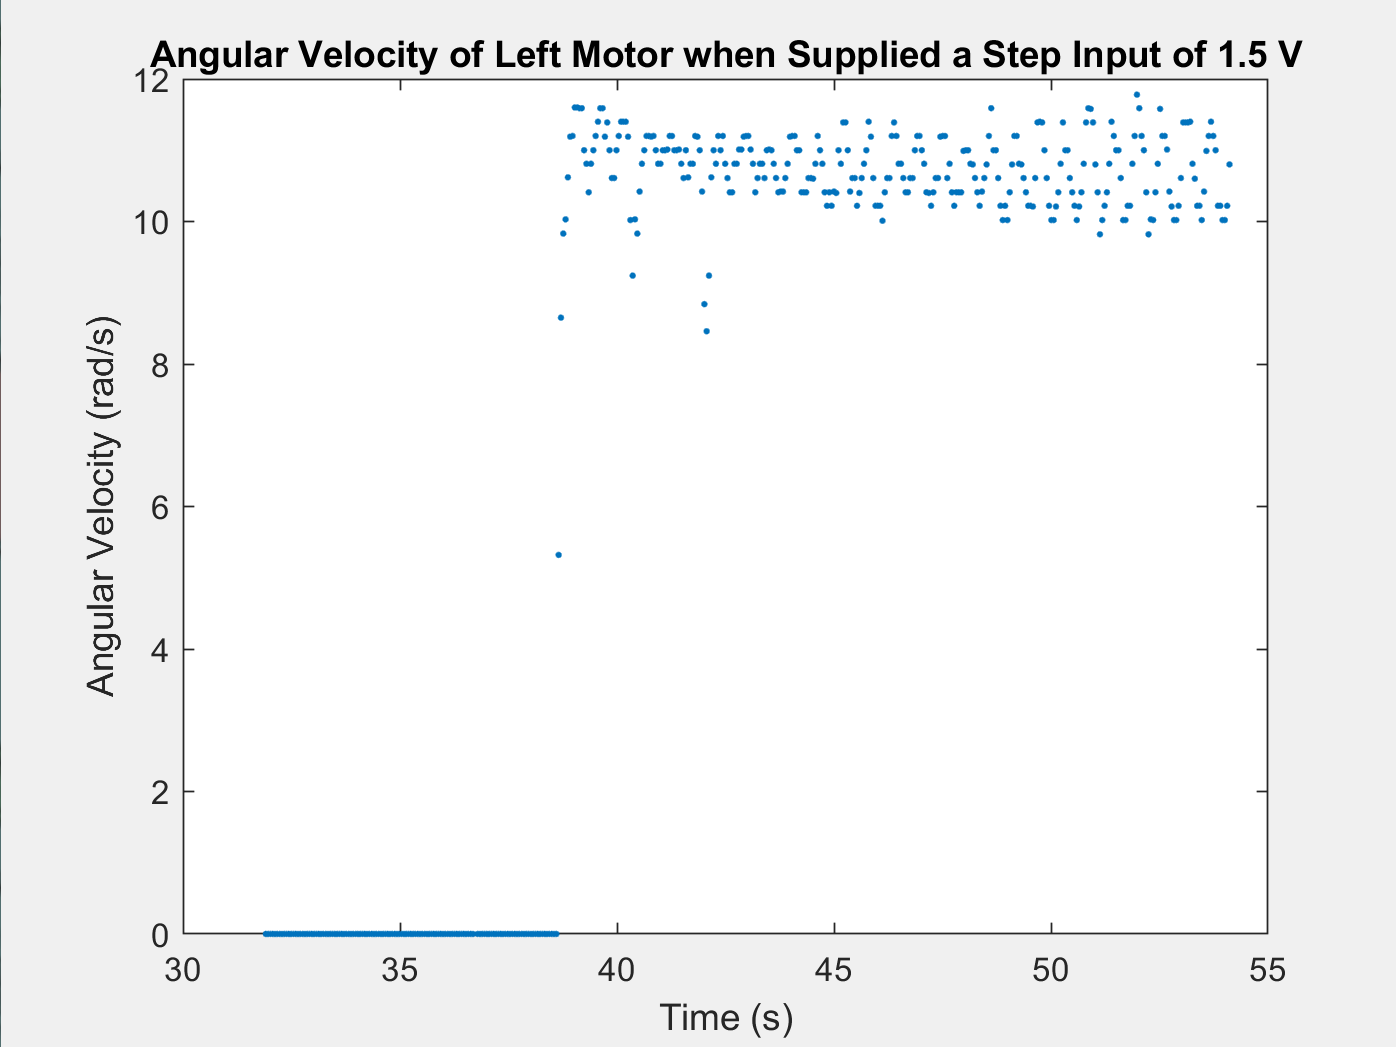

Once all system elements have been chosen, the next step was to derive a differential equation to describe the model's behavior in terms of the desired input, output, and the system's elements. Below is the linear graph, differential equation development, and the single equation that describes the angular velocity as a function of time with voltage as an input: 

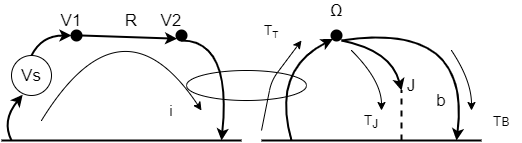

Elemental equations: 
1. $V_{12} = iR$
2. $K_t i = T_m$
3. $V_{2g} = K_t \Omega$
4. $T_b = b\Omega$
5. $T_J = J\dot{\Omega}$

Loop equations:

6. $V_s = V_{12} + V_{2g}$

Node equations: 

7. $T_m = T_b + T_J$

Model Derivation: 

$ T_m = T_b + T_J $ --> $ K_t i = b\Omega + J\dot{\Omega} $ --> $K_t \frac{V_{12}}{R} = b\Omega + J\dot{\Omega} $ --> $\frac{K_t}{R} (Vs-V_{2g}) = b\Omega + J\dot{\Omega} $ --> $\frac{K_t}{R} (Vs-K_t \Omega) = b\Omega + J\dot{\Omega} $

Final Equation: 
$ J\dot{\Omega} + (b + \frac{K_t^2}{R})\Omega = \frac{K_t}{R}V_s $

The next step in model development was to determine numerical values for J, b, $K_t$, and R for both the left and right motors. 

The values for $K_t$ and R were determined using the data sheet associated with this Zumo model. From the data sheet (https://www.pololu.com/product/3125), the stall torque is reported to be 15 oz$\cdot$in or 1.08 kg$\cdot$cm. The stall current and stall voltage were reported to be 1.6 A and 6 V, respectively. Using these values, $K_t$ and R were determined: 

$K_t = \frac{T_{stall} g}{i_{stall}} = \frac{(1.08kg\cdot cm)(\frac{1 m}{100 cm})(9.81 m/s^2)}{1.6 A} = 0.0662 \frac{N\cdot m}{A}$ 

$R = \frac{V_{stall}}{i_{stall}} = \frac{6 V}{1.6 A} = 3.75 \Omega$

In order to determine values for J and b, data collection was required. For each motor, I collected data with an input voltage of 1.5 V to 4.0 V in increments of 0.5 V and conducting two trials for each input voltage. The data I collected consisted of time, distance traveled, current battery voltage reading, the input voltage (1.5-4.0 V), count written to the motor, and angular velocity. 

To determine the damping coefficient (b), I found the transfer function corresponding to my model's differential equation and utilized the final value theorem:

$J\dot{\Omega} + (b + \frac{K_t^2}{R})\Omega = \frac{K_t}{R}V_s$ -->  $\dot{\Omega} + (\frac{K_t^2 + Rb}{RJ})\Omega = \frac{K_t}{RJ}V_s$ 

Laplace --> $ sY(s) + (\frac{K_t^2 + Rb}{RJ})Y(s) = \frac{K_t}{RJ}U(s)$ --> $\frac{Y(s)}{U(s)} = \frac{\frac{K_t}{RJ}}{s+\frac{K_t^2 + Rb}{RJ}} = \frac{K_t}{RJs + (K_t^2 + Rb)}$ --> $Y(s) = \frac{K_t}{RJs + (K_t^2 + Rb)} U(s)$

$\Omega_{ss} = \lim_{s \to 0} sY(s) = \lim_{s \to 0} s\cdot \frac{U(s)}{s} \frac{K_t}{RJs + (K_t^2 + Rb)}$ --> $\Omega_{ss} = \frac{V_s K_t}{(K_t^2 + Rb)}$

For each data set, the steady state angular velocity ($\Omega_{ss}$) was determined by averaging the last 50 angular velocity data points. Thus the damping coefficient was able to be determined using each data set for both the left and right motor, as well as the determined values for Kt and R. 

However, upon collecting values for the damping coefficient from each data set, I found that there was a nonlinear correlation between the damping coefficient (b) and the input source voltage (Vs). More specifically, the damping coefficient seemed to exponentially decrease with increasing voltage. Thus, I decided to curve fit the several damping coefficient values I calculated from all data sets and determine a relationship that relates input source voltage and damping coefficient. For the left motor, I found the following correlation: $b_{left} =  0.004912e^{-1.834V_s} + 0.001301e^{-0.1845V_s}$. For the right motor, I found the following correlation: $b_{right} = 0.005741e^{-1.488V_s} + 0.0008965e^{-0.06323V_s}$. Below is a graph showing the experimental data of damping coefficient with varying input source voltage plotted against the curve fitted correlation. 

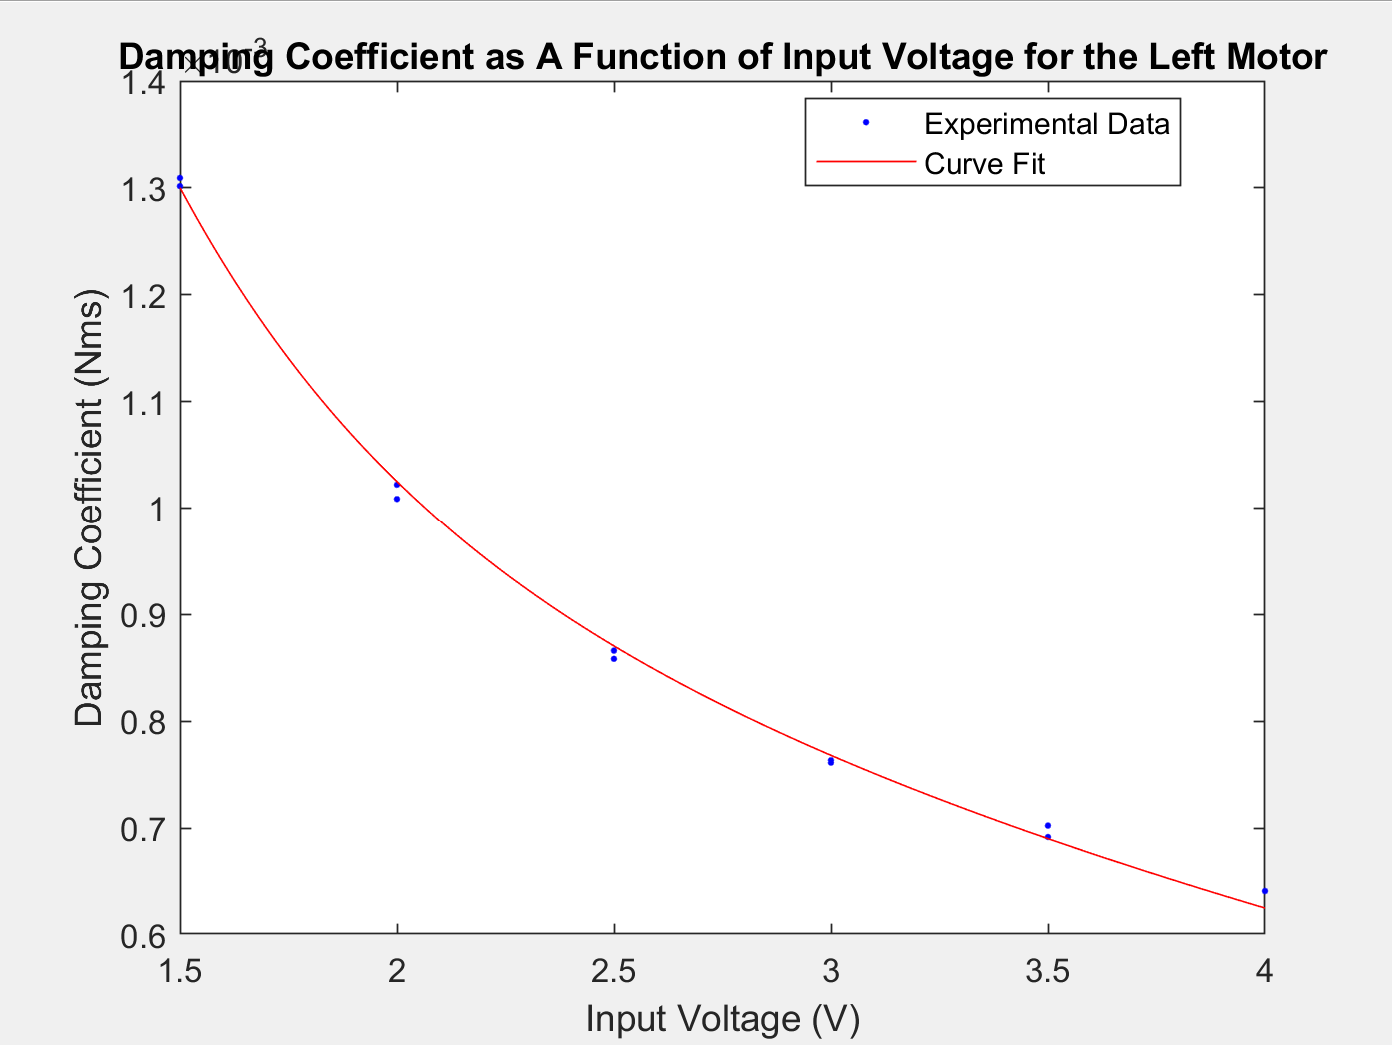

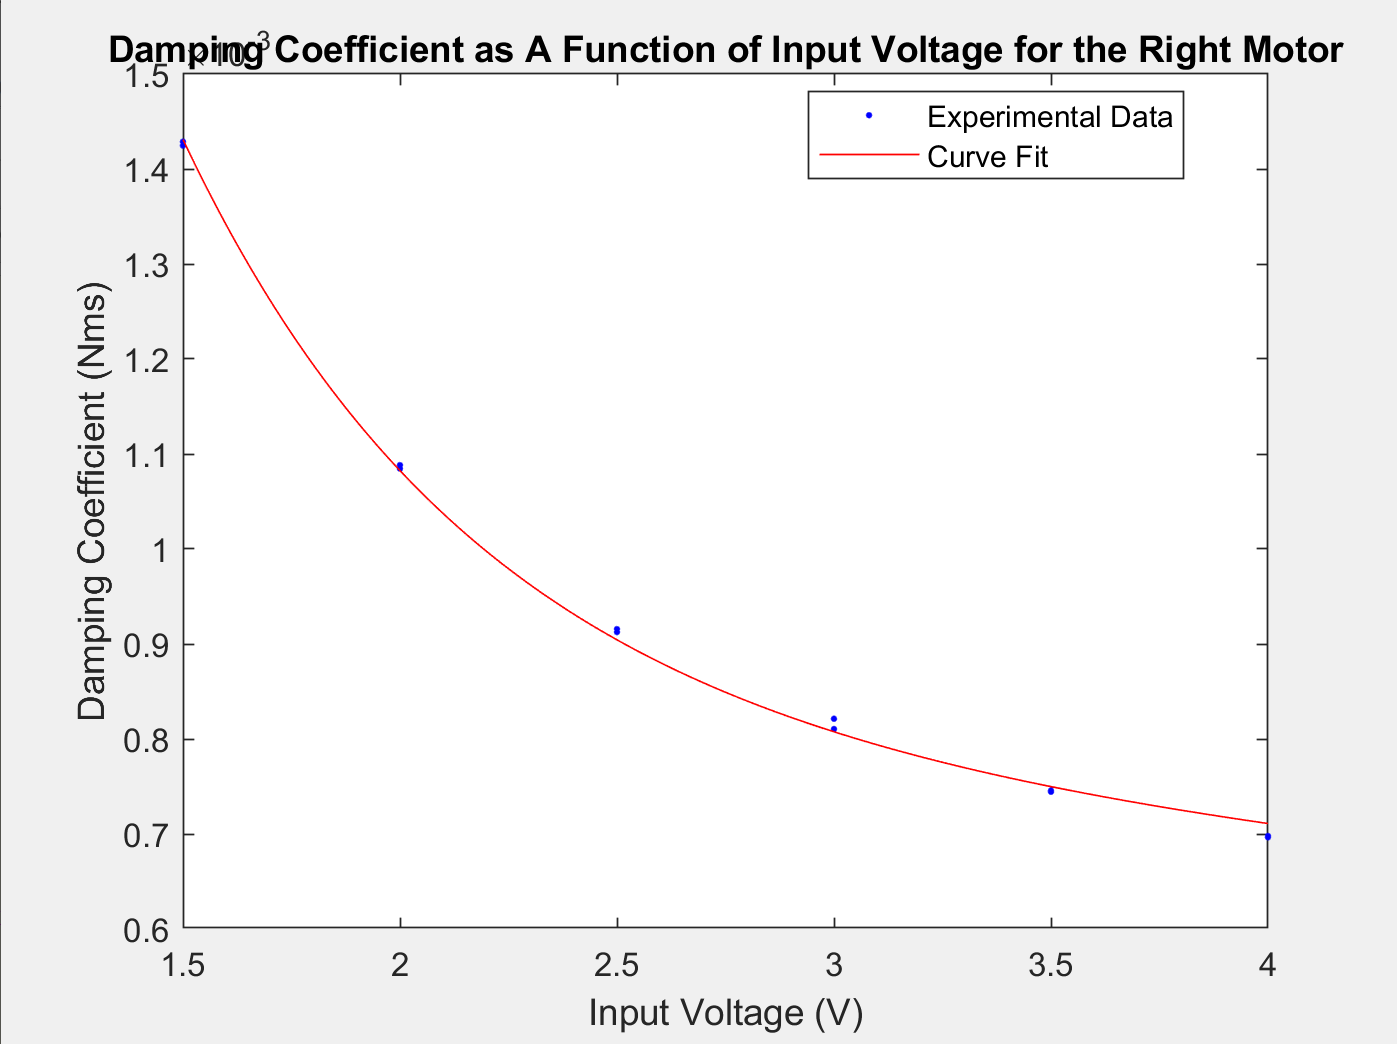

The last system parameter to determine is the rotational inertia of the motor (J) and incorporate any added mass to the system. In order to determine the rotational inertia of both the left and right motors, the same datasets were analyzed, but now evaluating the time constant. Since we know that $\tau = -\frac{1}{p}$ where p is the system's pole, I found an expression that relates the rotational inertia of the motor to the time constant: 

$\dot{\Omega} + (\frac{K_t^2 + Rb}{RJ})\Omega = \frac{K_t}{RJ}V_s$ --> $p + (\frac{K_t^2 + Rb}{RJ}) = 0$ --> $p = -\frac{K_t^2 + Rb}{RJ}$ 

$\tau = -\frac{1}{p} = \frac{RJ}{K_t^2 + Rb}$

Using the collected data, I was able to determine the time constant ($\tau$) as when time is equal to the time constant, 63.2% of the change between the starting value and the steady state value has occurred. 

The values for rotational inertia of the left and right motors were consistent through all trials, so the final values for rotational inertia were averaged over all the trials. The values for rotational inertia for both motors were found to be:

$J_{left} = 0.000109 kg\cdot m^2$

$J_{right} = 0.000113 kg\cdot m^2$

In order to incorporate the effects of an added mass, the total rotational inertia was calculated:

$J_{tot,left} = J_{left} + \frac{1}{4}mr^2$ 

$J_{tot,right} = J_{right} + \frac{1}{4}mr^2$

where m is the mass of the added weight and r is the radius of the wheel. This relationship was found by using the equation for moment of inertia $J = \frac{1}{2}mr^2$, but multiplying this then by one half as it was assumed that half the rotational inertia contributed by the added weight would affect the left motor and the other half would affect the right motor. 

Once values for J, b, $K_t$, and R were determined, I then needed to establish a relationship that related input source voltage, desired distance, and desired time. My next step was to take the integral of my model's transfer function in order to have a relationship that connected input voltage to angular distance ($\theta$). Taking the integral of a transfer function is equivalent to multiplying by $\frac{1}{s}$, thus the transfer function relating input voltage and angular distance is:

$\frac{\Omega(s)}{V_s(s)} = \frac{K_t}{RJs + (K_t^2 + Rb)}$ --> $\frac{\theta(s)}{V_s(s)} = \frac{K_t}{RJs^2 + (K_t^2 + Rb)s}$

In order to find an equation for the angular distance, the expression can be rewritten as:

$\frac{\theta(s)}{V_s(s)} = \frac{K_t}{RJs^2 + (K_t^2 + Rb)s}$ --> $\theta(s) = V_s(s)\frac{K_t}{RJs^2 + (K_t^2 + Rb)s}$

Since $V_s$ is a step input of some input voltage, the expression simplifies to:

$\theta(s) = \frac{1}{s}\frac{K_t}{RJs^2 + (K_t^2 + Rb)s}$ --> 
$\theta(s) = \frac{K_t}{RJs^3 + (K_t^2 + Rb)s^2}$

The next step was to take this out of the laplace domain and into the time domain in order to get an expression relating input voltage, distance, and time. Using MATLAB, the inverse laplace of this expression was derived using the ilaplace() MATLAB function. 

The inevitable goal of this analysis is to be able to input a desired time and distance and receive an output of input voltage required to travel that distance in that amount of time based on the model of the two motors. Therefore, the next step was to convert the expression into something that would return input source voltage. Dividing the desired angular distance value by the result from the inverse laplace expression above, an expression for voltage was obtained. The desired angular distance can be determined by knowing that an angular distance of $2\pi$ correlates to a the circumference of the wheel. The correlation is as follows:

$2\pi$ radians = $2\pi r$ = $2\pi(0.0185 m)$ --> $2\pi$ radians = 0.116 m    

where r = 0.0185 is the radius of the wheel that I explicitly measured. Using this correlation, the desired distance can be converted into a desired angular distance by:

$\theta_{desired} = x_{desired} \frac{2\pi}{0.116}$. 

Once an expression for input voltage is determined by dividing the desired angular distance by the result of the inverse laplace, the desired time can be substituted into this expression to determine a numerical result for input source voltage. 

The final step is to account for the nonlinear damping and its dependence on the input source voltage. Although a value for input voltage was able to be determined following the above analysis, this analysis utilized the average value for damping coefficient. However, the damping coefficient is dependent on the input voltage (as discussed above). Therefore, in order to accurrately determine a value for input voltage, iteration until convergence to an input voltage value was executed. Using the input voltage determined above, the damping coefficient was calculated using the exponential relationships determined through curve fitting (seen above). Then, using this new damping coefficient, a new value for input voltage was determined following the same procedure previously outlined. This was continually executed until the input source voltage value converged to an accuracy of 0.001 V. 

This procedure was completed using the model for both the left and right motors and returning the values for input voltage to be supplied to the motors separately. 

# Performance Assessment

Describe the task here!

On demonstration day, we were given a desired distance and time for two scenarios: one "near" and one "far" set of conditions. For both scenarios, I would input the desired distance and time into the MATLAB program I had developed and it would return the input voltages for both motors. It should be noted that the desired distance given on demostration day was relative to the final position of the center of the Zumo's body. Therefore, the actual distance that was used in the analysis to determine input voltages was the given desired distance plus half the length of the Zumo (determined to be 0.0475 m throught measurement). 

Overall, the Zumo's performance on demonstration day was excellent. In both the "far" and "near" scenarios, the Zumo landed in the centered zone. For the "near" scenario, to meet the requirements of desired distance and time, the input voltages were relatively larger than those supplied for the "far" scenario. Due to this and the abrupt stopping of the Zumo once the desired time had surpassed, the final position of the Zumo for the "near" scenario was slightly crooked, but overall still within the general centered zone. 

In general, I was extremely satisfied with the Zumo's performance as well as the generality and malleability of the motor models I constructed to create accurrate results for a variety of inputs.

# Next Steps

Since the Zumo's perfomance on demonstration day met all requirements and finished in the centered zone, no further steps were taken to improve the design of the Zumo model nor the finite state machine. 